Необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность
подключения услуги.

# Данные
В качестве исходных данных вам будет доступна информация об отклике
абонентов на предложение подключения одной из услуг. Каждому пользователю
может быть сделано несколько предложений в разное время, каждое из которых он
может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный
анонимизированный набор признаков, характеризующий профиль потребления
абонента. Эти данные привязаны к определенному времени, поскольку профиль
абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test
отложен последующий месяц.

Итого, в качестве входных данных будут представлены:
- ● data_train.csv: id, vas_id, buy_time, target
- ● features.csv.zip: id, <feature_list>
И тестовый набор:
- ● data_test.csv: id, vas_id, buy_time

- id - идентификатор абонента
- buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
- vas_id - подключаемая услуга
- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.



Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для
работы с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться
библиотекой Dask.

# Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например
делает функция sklearn.metrics.f1_score(…, average=’macro’).
sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation
Формат представления результата
1. Работающая модель в формате pickle, которая принимает файл data_test.csv
из корневой папки и записывает в эту же папку файл answers_test.csv. В этом
файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно
записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука.
3. Презентация в формате .pdf, в которой необходимо отразить:
● Информация о модели, ее параметрах, особенностях и основных
результатах.
● Обоснование выбора модели и ее сравнение с альтернативами.
● Принцип составления индивидуальных предложений для выбранных
абонентов.
Рекомендуемое количество слайдов – 5 – 10.
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и
резюме необходимо прикрепить ко второму уроку “курсовой проект”.

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import seaborn as sns
from datetime import datetime

from scipy.stats import boxcox, probplot
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


### Обзор данных

In [28]:
data_train = pd.read_csv('data_train.csv')
data_train.shape

(831653, 5)

In [29]:
data_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [30]:
#Преобразуем время в другой формат
#data_train['data_time'] = data_train.apply(lambda x: datetime.fromtimestamp(x['buy_time']), axis =  1)

In [31]:
data_test = pd.read_csv('data_test.csv')
data_test.shape

(71231, 4)

In [32]:
#Преобразуем время в другой формат
#data_test['data_time'] = data_train.apply(lambda x: datetime.fromtimestamp(x['buy_time']), axis =  1)

In [33]:
data_test.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [74]:
data_test.tail()

,id,vas_id,buy_time
Unnamed: 0,,,
71226,2502453,5.0,1548018000
71227,1693213,2.0,1548018000
71228,1891350,2.0,1548018000
71229,2437172,2.0,1548018000
71230,988236,2.0,1548018000


In [34]:
data_features = dd.read_csv('features/features.csv', sep='\t')


In [35]:
data_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [36]:
# Идея сделать операцию конкантинации межу фичами и данными из обучающего датасета не увенчалась успехом, закончилась память.

In [37]:
#dfs=dd.concat([data_train,data_features],axis=0,interleave_partitions=True)

In [38]:
#dfs.tail()

In [39]:
#print(dfs.compute())

### 1.1 Данные

In [40]:
data_train = data_train.set_index('Unnamed: 0')

In [41]:
data_train

,id,vas_id,buy_time,target
Unnamed: 0,,,,
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0
...,...,...,...,...
831648,3812226,2.0,1546203600,0.0
831649,2480469,2.0,1546203600,0.0
831650,158236,2.0,1546203600,0.0


In [42]:
# Разделим признаки и целевую переменную
data_prelim = data_train.copy()

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

In [43]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0%


### 1.2 Разделяем на train и test

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

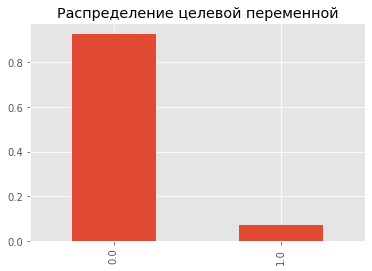

In [44]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [45]:
from sklearn.model_selection import train_test_split

# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 888

train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.927521
1.0    0.072479
Name: target, dtype: float64

Test
0.0    0.927961
1.0    0.072039
Name: target, dtype: float64


### 1.3 Pipeline для baseline модели

Для построения baseline модели будем использовать логистическую регрессию.

In [46]:
from sklearn.linear_model import LogisticRegression

step_log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))

In [47]:
from sklearn.pipeline import Pipeline

bl_estimator = Pipeline([
    step_log_reg
])

### 1.4 Кросс-валидация

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

* Folds: 1 2 3
    * Train: 1,2 Val: 3
    * Train: 1,3 Val: 2
    * Train: 2,3 Val: 1

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Варианты:
- ‘precision’, ‘recall’, ‘accuracy’, ‘f1’
- ‘average_precision’, ‘roc_auc’

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

Посмотрим на значение метрики на кросс-валидации, оно понадобится для сравнения с последующими моделями.

In [49]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.56 (+/- 0.00)


### 1.5 Графики и метрики baseline модели на тесте

In [50]:
bl_estimator.fit(X_train, y_train)

bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]

In [53]:
X_test

,id,vas_id,buy_time
Unnamed: 0,,,
581882,2037881,1.0,1544994000
354454,347992,6.0,1532898000
366075,3586852,1.0,1534107600
323931,4285910,1.0,1535317200
625250,759496,4.0,1535922000
...,...,...,...
331908,4159278,1.0,1532898000
352005,3863804,1.0,1534107600
405410,4182353,5.0,1540155600


#### Распределение предсказаний baseline модели

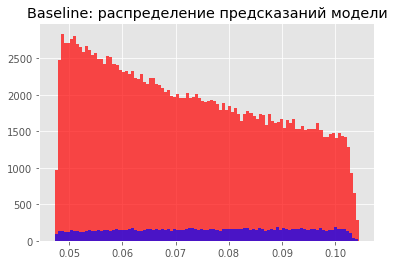

In [51]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

#### Roc и PR Кривые

In [52]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.568


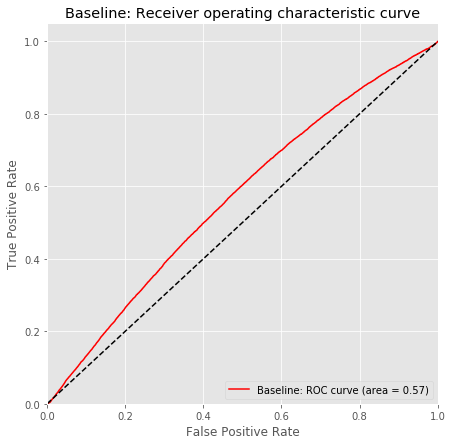

In [53]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.085


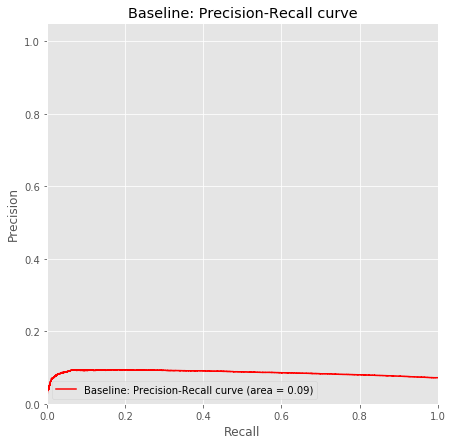

In [54]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

Допустим, мы хотим построить классификатор, который будет находить не менее 65% multisim абонентов. Соответственно, имеем нижнюю границу 80% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога?

Максимальную точность при этом: 0.085
При каком пороге: 0.068


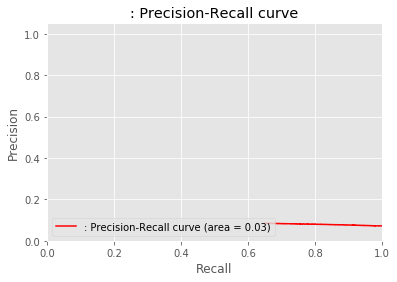

In [57]:
re80_mask = recall >= 0.65
pr_target_idx = np.arange(len(precision))[re80_mask]
pr_target = precision[re80_mask]

max_pr_idx = pr_target_idx[np.argmax(pr_target)]


print("Максимальную точность при этом: %.3f" % precision[max_pr_idx])
threshold80 = pr_thresholds[max_pr_idx]
print ("При каком пороге: %.3f" % threshold80)

plot_precision_recall_curve(recall[re80_mask], precision[re80_mask], color='r')

#### Матрица смежности

In [58]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[192936      0]
 [ 14978      0]]


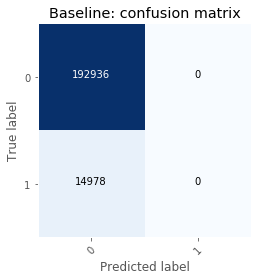

In [72]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_test, bl_y_pred > 0.11)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

#### classification_report

In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_test, bl_y_pred > 0.11))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    192936
         1.0       0.00      0.00      0.00     14978

    accuracy                           0.93    207914
   macro avg       0.46      0.50      0.48    207914
weighted avg       0.86      0.93      0.89    207914



In [76]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(fp + tp)
recall = tp/(fn + tp)

accuracy = (tp + tn)/(fp + fn + tp + tn)

micro_avg_pr    = (tn + tp) / (fn + tn + fp + tp)
macro_avg_pr    = (tn/(fn + tn) + tp/(fp + tp))/2

n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
weighted_avg_pr = (n_0*tn/(fn + tn) + n_1*tp/(fp + tp))/(n_0 + n_1)

print("              accuracy = %.2f"   % float(accuracy))
print("           1 precision = %.2f"   % float(precision))
print("              1 recall = %.2f"   % float(recall))
print("   micro avg precision = %.2f "  % float(micro_avg_pr))
print("   macro avg precision = %.2f "  % float(macro_avg_pr))
print("weighted avg precision = %.2f "  % float(weighted_avg_pr))

              accuracy = 0.93
           1 precision = nan
              1 recall = 0.00
   micro avg precision = 0.93 
   macro avg precision = nan 
weighted avg precision = nan 


#### Сформируем массив предсказаний

In [55]:
data_test = data_test.set_index('Unnamed: 0')

In [56]:
data_pred = bl_estimator.predict_proba(data_test)[:,1]

In [60]:
data_pred

array([0.05893888, 0.07211475, 0.08465572, ..., 0.07352756, 0.06673119,
       0.08618318])